# Stima del costo di un auto
In questo script cercherò di calcolare il costo di mantenimento ordinario di un auto, tuttavia essendo un profano in materia mi sono rifatto a informazioni di varie testate online e a esperienze di amici, quindi non prendetela come una guida assoluta.<br>
Inoltre molte delle informazioni utilizzate sono estremamente variabili (costo carburante) o approssimative (consumi di un generico motore a benzina/diesel/...) e alcune sono addirittura omesse per via della loro volatilità (tagliandi e assicurazioni).

In [1]:
import matplotlib.pyplot as plt
import datetime
import copy

## Passaggio di proprietà
Il passaggio di proprietà, fatto solo in caso di auto usata, dipende dai kW e da una sovratassa locale che varia da provincia a provincia.<br>
Qui è riportato il costo "base", ovvero quello tra privati; in concessionari o agenzie il costo può differire.

[Fonte](https://www.autoscout24.it/informare/consigli/burocrazia-auto/passaggio-di-proprieta-auto-calcolo-costi-tabella-e-come-si-fa/#7pezdcardsSBK01lnlGLDg)

In [2]:
def passProp(auto: dict, sovra: float=0.3) -> float:
    """
    Questa funzione calcola l'importo del passaggio di proprietà dell'auto.

    Parametri:
    auto (dict): L'auto di cui calcolare il passaggio di proprietà.
    sovra (float): La sovratassa da applicare al passaggio di proprietà.

    Restituisce:
    Il costo del passaggio di proprietà dell'auto
    """
    check = [0.1, 0.15, 0.2, 0.25, 0.3]
    #controllo validità sovratassa inserita
    if sovra/100 in check:
        sovra = sovra/100
    if not(sovra in check):
        print("Valore di sovratassa non valido, procedo col più probabile (30%).")
        sovra=0.3
    #se l'auto è usata si ritorna il corrispetivo valore
    if auto["usata"]:
        if auto["kw"]<54:
            #importo base in bollo+IPT
            return 58.2+151
        else:
            return 58.2+(1+sovra)*(auto["kw"]*3.5119)
    return 0

## Bollo auto
Il bollo è una spesa annuale che dipende da potenza e classe di efficienza dell'auto.<br>
La tabella per calcolare a mano l'importo del bollo è la seguente:<br>
* Euro 0: € 3 a kW fino a 100 kW e € 4,5 per ogni kW oltre i 100 kW.
* Euro 1: € 2,9 a kW fino a 100 kW e € 4,35 per ogni kW oltre i 100 kW.
* Euro 2: € 2,8 a kW fino a 100 kW e € 4,2 per ogni kW oltre i 100 kW.
* Euro 3: € 2,7 a kW fino a 100 kW e € 4,05 per ogni kW oltre i 100 kW.
* Euro 4, Euro 5 ed Euro 6: € 2,58 a kW fino a 100 kW e € 3,87 per ogni kW oltre i 100 kW.

C'è inoltre da considerare il Superbollo per auto particolarmente potenti.

[Fonte](https://www.alvolante.it/da_sapere/legge-e-burocrazia/bollo-auto-calcolo-scadenza-ed-esenzione-guida-378630)

In [3]:
def calcoloBollo(auto: dict, anno: float) -> float:
    """
    Questa funzione calcola l'importo del bollo di un'auto.

    Parametri:
    auto (dict): L'auto di cui calcolare il bollo.
    anno (int): anno in cui si vuole calcolare il bollo.

    Restituisce:
    Il valore del bollo in euro
    """
    kw = auto["kw"]
    euro = auto["euro"]
    imm = auto["anno"]
    bollo = 0
    c1, c2 = 0, 0
    #definizione dei costi per kW in base alla classe
    if euro == 0:
        c1, c2 = 3, 4,5
    elif euro == 1:
        c1, c2 = 2.9, 4.35
    elif euro == 2:
        c1, c2 = 2.8, 4.2
    elif euro == 3:
        c1, c2 = 2.7, 4.05
    elif euro>3 and euro<7:
        c1, c2 = 2.58, 3.87
    else:
        print("Classe non valida.")
        return 0
    #clacolo dell'importo effettivo
    if kw<=100:
        return c1*kw
    else:
        bollo = c1*100+c2*(kw-100)
        if kw>185:
            superbollo = 20*(kw-185)
            if anno-imm<5:
                bollo = bollo + superbollo
            elif anno-imm<10:
                bollo = bollo + 0.6*superbollo
            elif anno-imm<15:
                bollo = bollo + 0.3*superbollo
            elif anno-imm<20:
                bollo = bollo + 0.15*superbollo
        return bollo

## Costo carburante
Questa variabile non è facilmente trattabile, in quanto il consumo di carburante varia non solo da veicolo a veicolo ma anche da guidatore a guidatore. Inoltre i vari tipi di carburante (GPL, benzina, diesel, metano) hanno concentrazioni di energia diverse e i prezzi cambiano in base al periodo e alla zona.<br>
Di seguito utilizzerò i prezzi medi della mia regione riportati dal [sito ufficiale](https://www.mimit.gov.it/it/prezzo-medio-carburanti/regioni) del ministero competente (modificateli in base alla vostra regione di residenza), mentre per i consumi vi lascio una media dei consumi di vari modelli riportati sul sito [motor1](https://it.motor1.com/reviews/213238/le-auto-che-consumano-meno-la-classifica-del-roma-forli/), ma il consumo specifico dell'auto viene specificato come caratteristica dell'auto stessa.<br>
Questa sezione, nonostante sia la più importante e la più onerosa, è anche la meno "standardizzabile" e precisa in quanto i prezzi variano moltissimo e motori diversi consumeranno in maniera diversa, ma anche lo stile di guida influenza pesantemente i consumi.

In [4]:
#Prezzo del carburante
prezzo = {
    "benzina":1.840,
    "diesel":1.725,
    "gpl":0.688,
    "metano":1.264
}

# Dati dei consumi in L/100 km
consumi = [
    3.65, 3.70, 3.70, 3.75, 3.90, 3.90, 3.95, 4.00, 4.00, 4.00, 4.00, 4.05, 4.05, 4.10, 4.10, 4.10,
    4.15, 4.15, 4.15, 4.20, 4.20, 4.25, 4.25, 4.25, 4.25, 4.30, 4.30, 4.30, 4.35, 4.35, 4.35, 4.35,
    4.40, 4.40, 4.45, 4.45, 4.50, 4.50, 4.50, 4.50, 4.55, 4.55, 4.55, 4.60, 4.60, 4.65, 4.70, 4.70,
    4.70, 4.75, 4.75, 4.75, 4.75, 4.80, 4.83, 4.85, 4.90, 4.90, 4.90, 4.95, 5.00, 5.00, 5.00, 5.00,
    5.00, 5.00, 5.00, 5.00, 5.03, 5.05, 5.05, 5.10, 5.10, 5.20, 5.20, 5.20, 5.25, 5.25, 5.25, 5.25,
    5.25, 5.35, 5.35, 5.40, 5.45, 5.48, 5.50, 5.50, 5.55, 5.60, 5.60, 5.80, 6.00, 6.00, 6.00, 6.20,
    6.30, 6.40, 6.40, 6.50, 6.60, 6.70, 6.70, 7.15, 7.35, 7.50, 7.60, 8.45, 10.50
]
# Calcolo della media
media_consumi = sum(consumi) / len(consumi)
print(f"La media dei consumi di un motore a benzina è: {media_consumi:.2f} L/100 km")

consumi = [
    3.00, 3.10, 3.15, 3.28, 3.30, 3.34, 3.35, 3.35, 3.36, 3.40,
    3.40, 3.45, 3.47, 3.50, 3.50, 3.50, 3.60, 3.60, 3.60, 3.60,
    3.63, 3.65, 3.70, 3.75, 3.75, 3.75, 3.80, 3.80, 3.80, 3.85,
    3.85, 3.85, 3.85, 3.90, 3.95, 4.00, 4.00, 4.00, 4.05, 4.05,
    4.10, 4.10, 4.10, 4.10, 4.13, 4.15, 4.20, 4.20, 4.20, 4.20,
    4.20, 4.25, 4.25, 4.30, 4.30, 4.30, 4.30, 4.33, 4.35, 4.35,
    4.37, 4.40, 4.40, 4.40, 4.44, 4.45, 4.45, 4.45, 4.50, 4.50,
    4.50, 4.50, 4.55, 4.55, 4.60, 4.60, 4.60, 4.60, 4.60, 4.65,
    4.65, 4.65, 4.70, 4.70, 4.75, 4.80, 4.80, 4.80, 4.80, 4.80,
    4.80, 4.85, 4.85, 4.90, 4.93, 4.97, 5.00, 5.00, 5.10, 5.10,
    5.10, 5.20, 5.20, 5.20, 5.25, 5.30, 5.30, 5.40, 5.45, 5.45,
    5.45, 5.50, 5.55, 5.70, 5.70, 5.70, 5.73, 5.80, 5.80, 5.80,
    5.90, 5.90, 5.90, 6.00, 6.15, 6.20, 6.40, 7.10, 7.20, 7.20,
    7.30, 7.30, 7.50, 7.50, 7.65, 8.50, 8.90
]
# Calcolo della media
media_consumi = sum(consumi) / len(consumi)
print(f"La media dei consumi di un motore a diesel è: {media_consumi:.2f} L/100 km")

consumi = [
    5.20, 5.50, 5.55, 5.65, 5.85, 6.19, 6.39, 6.45, 6.45, 6.50,
    6.55, 6.60, 6.65, 6.80, 6.80, 6.80, 7.00, 7.18, 7.50, 7.60,
    7.65, 7.70, 7.90, 7.90, 8.20, 8.60
]
# Calcolo della media
media_consumi = sum(consumi) / len(consumi)
print(f"La media dei consumi di un motore a GPL è: {media_consumi:.2f} L/100 km")

consumi = [
    2.55, 2.65, 2.68, 2.90, 2.90, 3.14, 3.15, 3.20, 3.25, 3.30,
    3.40, 3.40, 3.45, 3.60, 3.60, 3.60, 4.06
]
# Calcolo della media
media_consumi = sum(consumi) / len(consumi)
print(f"La media dei consumi di un motore a metano è: {media_consumi:.2f} L/100 km")

consumi = [
    3.20, 3.46, 3.55, 3.60, 3.70, 3.70, 3.88, 3.90, 3.95, 3.95,
    4.00, 4.00, 4.00, 4.10, 4.10, 4.10, 4.15, 4.20, 4.20, 4.25,
    4.25, 4.30, 4.35, 4.40, 4.40, 4.40, 4.40, 4.43, 4.45, 4.45,
    4.45, 4.50, 4.50, 4.55, 4.60, 4.65, 4.74, 4.75, 4.80, 4.80,
    4.80, 4.83, 5.00, 5.00, 5.20, 5.20, 5.30, 5.40, 5.40, 5.45,
    5.50, 5.60, 5.85, 6.05, 6.10, 6.10, 6.50, 6.70, 6.85, 7.45

]
# Calcolo della media
media_consumi = sum(consumi) / len(consumi)
print(f"La media dei consumi di un'auto full hybrid è: {media_consumi:.2f} L/100 km")


La media dei consumi di un motore a benzina è: 5.02 L/100 km
La media dei consumi di un motore a diesel è: 4.70 L/100 km
La media dei consumi di un motore a GPL è: 6.81 L/100 km
La media dei consumi di un motore a metano è: 3.23 L/100 km
La media dei consumi di un'auto full hybrid è: 4.71 L/100 km


In [5]:
def calcoloCarb(auto: dict, prezzo: dict, km: float=10000) -> float:
    """
    Questa funzione stima la spesa annuale in carburante.

    Parametri:
    auto (dict): L'auto di cui calcolare la spesa per il carburante.
    km (float): kilometri annui che l'auto deve compiere.

    Restituisce:
    La spesa in carburante in euro.
    """
    prezzo = {
        "benzina":1.840,
        "diesel":1.725,
        "gpl":0.688,
        "metano":1.264
    }
    carb = auto["carb"].lower()
    if carb in prezzo:
        return prezzo[carb]*auto["cons"]*km/100
    else:
        print("Carburante non valido.")
        return 0

## Revisione
La revisione (non il tagliando) viene effettuata ogni 2 anni e in caso di auto a GPL o metano vi è da considerare anche il cambio delle bombole.
Il cambio delle bombole nel caso di auto a GPL va fatto ogni 10 anni e il suo costo è assai variabile (qui userò 500 euro come valore indicativo).<br>
Nel caso di auto a metano invece la questione è più complessa: le bombole possono avere due omologazioni diverse, con periodi di controllo differenti.<br>
In questo ambito considererò le auto a metano con bombole a certificazione nazionale (da controllare ogni 5 anni) e con un costo aggiuntivo di 150 euro sulla revisione.

In [6]:
def costoRev(auto: dict, anno: float) -> float:
    """
    Questa funzione calcola il costo della revisione dell'auto.

    Parametri:
    auto (dict): L'auto di cui calcolare la spesa per la revisione.
    anno (int): anno attuale in cui calcolare la revisione.

    Restituisce:
    La spesa in euro per la revisione.
    """
    c = 0
    if anno-auto["anno"]<4:
        return 0
    elif (anno-auto["anno"])%2==0:
        if auto["carb"].lower()=="gpl" and (auto["bombole"]-anno)%10==0:
            return 500+78.75
        elif auto["carb"].lower()=="metano" and (auto["bombole"]-anno)%5==0:
            return 150+78.75
        return 78.75
    else:
        return 0

In [7]:
def costoTempo(auto: dict, prezzi: dict, anni: int=20, sovra: float=0.3, km: float=10000) -> list:
    """
    Questa funzione salva in un array il progredire delle spese per l'auto.

    Parametri:
    auto (dict): L'auto di cui calcolare la spesa nel tempo.
    anni (int): anni per cui si vogliono stimare le spese.
    sovra (float): sovratassa per il passaggio di proprietà.
    km (float): km annuali che si stima di percorre con l'auto.

    Restituisce:
    Una lista con il progredire delle spese.
    """
    now = datetime.datetime.now().year
    costo = []
    annuale = 0
    for i in range(anni+1):
        if i==0:
            annuale = auto["costo"]+passProp(auto, sovra)
        else:
            annuale = costo[i-1]
            annuale += costoRev(auto, now+i) + calcoloBollo(auto, now+i) + calcoloCarb(auto, prezzi, km)
        costo.append(annuale)
    return costo

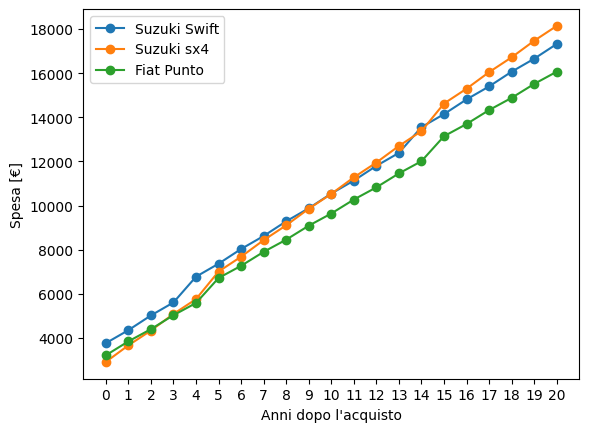

In [8]:
'''
Le informazioni di un'auto sono salvate in un dizionario, strutturato nel seguente modo:
    nome (string): Nome dell'auto
    anno (float): Anno di immatricolazione
    euro (float): Classe del veicolo
    kw (float): kW di potenza
    cons (float): consumi dell'auto
    costo (float): costo dell'auto
    usata (boolean): se l'auto è comprata usata oppure no
    carb (string): carburante usato dall'auto
    bombole (float): anno dell'ultima revisione delle bombole
'''

auto1 = {
    "nome":"Suzuki Swift",
    "anno":2008,
    "euro":4,
    "kw":68,
    "cons":6,
    "costo":3400,
    "usata":True,
    "carb":"gpl",
    "bombole":2018
}
auto2 = {
    "nome":"Suzuki sx4",
    "anno":2009,
    "euro":4,
    "kw":79,
    "cons":6.8,
    "costo":2500,
    "usata":True,
    "carb":"gpl",
    "bombole":2019
}
auto3 = {
    "nome":"Fiat Punto",
    "anno":2009,
    "euro":4,
    "kw":57,
    "cons":5.9,
    "costo":2900,
    "usata":True,
    "carb":"gpl",
    "bombole":2019
}

curr = datetime.datetime.now().year
vita = 20
costo1 = costoTempo(auto1, prezzo, vita)
#print(costo1)
costo2 = costoTempo(auto2, prezzo, vita)
#print(costo2)
costo3 = costoTempo(auto3, prezzo, vita)

plt.plot(costo1, marker="o", label=auto1["nome"]);
plt.plot(costo2, marker="o", label=auto2["nome"]);
plt.plot(costo3, marker="o", label=auto3["nome"]);
plt.xlabel("Anni dopo l'acquisto");
plt.ylabel("Spesa [€]");
plt.xticks(range(vita+1));
plt.legend();